In [1]:
# Run this once at the top of the notebook
!pip install -q requests pandas beautifulsoup4 matplotlib lxml

# (Optional) If you want nicer text processing later:
!pip install -q wordfreq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00


In [2]:
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.max_rows', 40)


In [3]:
def check_robots_txt(base_url):
    if not base_url.startswith("http"):
        base_url = "https://" + base_url
    robots_url = base_url.rstrip('/') + "/robots.txt"
    try:
        r = requests.get(robots_url, timeout=10)
        print(f"robots.txt for {base_url}:\n")
        print(r.text[:1500])   # print first 1500 chars
    except Exception as e:
        print("Couldn't fetch robots.txt:", e)

# Example: check Remotive and RealPython demo
check_robots_txt("remotive.io")
check_robots_txt("realpython.github.io")


robots.txt for https://remotive.io:


        User-agent: *
        Sitemap:https://remotive.com/sitemap.xml

        User-agent: *
        Disallow: /*search=
        Disallow: /job/apply/*
        Disallow: /job/track/*
        Disallow: /job/application/*
        Disallow: /job/detail/*
        Disallow: /jobs/*
        Disallow: /job/report/*
        Disallow: /*sort=
        Disallow: /remote-job/detail/*
        Disallow: /remote-companies/page
        Disallow: /website_payment*
        Disallow: /api/*
        Disallow: /web/image/hr.job/*
        Disallow: /ajax/session*
        
robots.txt for https://realpython.github.io:

<!DOCTYPE html>
<html>
  <head>
    <meta http-equiv="Content-type" content="text/html; charset=utf-8">
    <meta http-equiv="Content-Security-Policy" content="default-src 'none'; style-src 'unsafe-inline'; img-src data:; connect-src 'self'">
    <title>Site not found &middot; GitHub Pages</title>
    <style type="text/css" media="screen">
      body {
   

In [5]:
import requests

url = "https://remotive.com/api/remote-jobs"   # note: updated base (remotive.com, not .io)

headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0 Safari/537.36"
}

resp = requests.get(url, headers=headers, timeout=15)
resp.raise_for_status()
jobs_json = resp.json()
jobs = jobs_json.get('jobs', [])
print("Fetched", len(jobs), "jobs")


Fetched 1471 jobs


In [6]:
from bs4 import BeautifulSoup

base = "https://realpython.github.io/fake-jobs/"
r = requests.get(base, headers=headers, timeout=10)
r.raise_for_status()
soup = BeautifulSoup(r.text, "lxml")

job_cards = soup.find_all("div", class_="card-content")
print("Found", len(job_cards), "fake job postings")


Found 100 fake job postings


In [7]:
jobs = []
for card in job_cards:
    title = card.find("h2", class_="title").get_text(strip=True)
    company = card.find("h3", class_="company").get_text(strip=True)
    location = card.find("p", class_="location").get_text(strip=True)
    link_tag = card.find('a')
    link = link_tag['href'] if link_tag else None
    detail_url = link if link and link.startswith("http") else base + (link.lstrip('/') if link else '')

    # fetch detail page for description
    dr = requests.get(detail_url, headers=headers, timeout=10)
    dsoup = BeautifulSoup(dr.text, "lxml")
    desc_node = dsoup.find('div', class_='content')
    desc = desc_node.get_text(" ", strip=True) if desc_node else ""

    jobs.append({
        'title': title,
        'company': company,
        'location': location,
        'url': detail_url,
        'description': desc
    })

df = pd.DataFrame(jobs)
df.head()


,title,company,location,url,description
0,Senior Python Developer,"Payne, Roberts and Davis","Stewartbury, AA",https://www.realpython.com,
1,Energy engineer,Vasquez-Davidson,"Christopherville, AA",https://www.realpython.com,
2,Legal executive,"Jackson, Chambers and Levy","Port Ericaburgh, AA",https://www.realpython.com,
3,Fitness centre manager,Savage-Bradley,"East Seanview, AP",https://www.realpython.com,
4,Product manager,Ramirez Inc,"North Jamieview, AP",https://www.realpython.com,


In [8]:
# Fill missing text safely
df = df.fillna({'description': '', 'title': ''})

# Combine into one text column for analysis
df['text'] = (df['title'] + " " + df['description']).str.lower()

df[['title','company','location','text']].head(3)


,title,company,location,text
0,Senior Python Developer,"Payne, Roberts and Davis","Stewartbury, AA",senior python developer
1,Energy engineer,Vasquez-Davidson,"Christopherville, AA",energy engineer
2,Legal executive,"Jackson, Chambers and Levy","Port Ericaburgh, AA",legal executive


DATAFRAME DIAGNOSTICS
df shape: (100, 6)
columns: ['title', 'company', 'location', 'url', 'description', 'text']

Column 'skills' not found — will attempt to extract from 'text' column (if available).

Sample df['text'] (first 3):
----
 senior python developer 
----
 energy engineer 
----
 legal executive 

Post-coercion types in df['skills']: {<class 'list'>: 100}
Sample df['skills'] (first 10): [['python'], [], [], [], [], [], [], [], [], []]

Top detected skills (first 20):
  skill  count
python     10
django      2


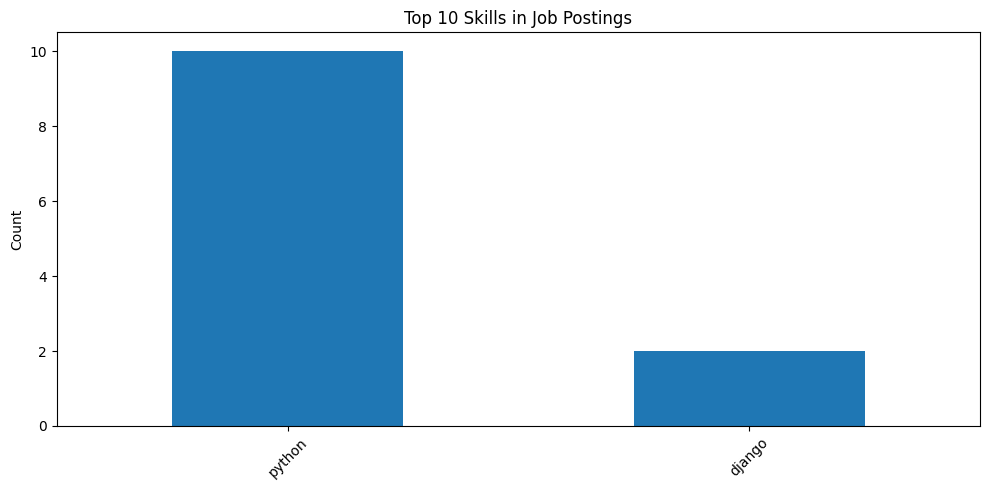


Saved: skill_counts.csv and job_postings_with_skills.csv in Colab working directory.


In [11]:
# Defensive diagnosis + conversion + explode + plot
import ast, re, pandas as pd, matplotlib.pyplot as plt

# ----- Diagnostics -----
print("DATAFRAME DIAGNOSTICS")
try:
    print("df shape:", df.shape)
    print("columns:", df.columns.tolist())
except NameError:
    raise RuntimeError("No DataFrame named `df` found. Run the scraping step (3B) first to create `df`.")

# show first 10 raw values & types in 'skills' if present
if 'skills' in df.columns:
    print("\nSample of raw df['skills'] (first 10) with types:")
    for i, v in enumerate(df['skills'].head(10)):
        print(i, type(v), "=>", repr(v)[:200])
else:
    print("\nColumn 'skills' not found — will attempt to extract from 'text' column (if available).")

# show sample 'text' column to help debug if needed
if 'text' in df.columns:
    print("\nSample df['text'] (first 3):")
    for t in df['text'].head(3):
        print("----\n", str(t)[:400])
else:
    print("\nNo 'text' column present. If you have only title/description, create df['text'] as (title + description).")

# ----- Prepare pattern and extractor -----
skills_list = [
    "python","sql","r","aws","azure","gcp","docker","kubernetes","tensorflow","pytorch",
    "pandas","numpy","scikit-learn","spark","hadoop","excel","tableau","power bi","javascript",
    "react","node","django","flask","fastapi","html","css","java","c++","c#","matlab",
    "nlp","computer vision","linux","git","rest api","api","keras","sas","scala","bash",
    "mongodb","postgresql","mysql","oracle","wordpress","php"
]
pattern = re.compile(r'\b(' + '|'.join(re.escape(s) for s in skills_list) + r')\b', flags=re.IGNORECASE)

def extract_skills_from_text(text):
    if not isinstance(text, str) or not text.strip():
        return []
    found = set(m.group(0).lower() for m in pattern.finditer(text))
    return sorted(found)

def coerce_to_list(x):
    """
    Convert various possible 'skills' cell values into a list of strings.
    Handles:
     - real lists
     - None / NaN -> []
     - string forms of lists like "['python', 'sql']"
     - comma-separated strings "python, sql"
     - free text -> extract keywords via regex
     - sets/tuples -> convert to list
    """
    # proper list: normalize elements to lowercase strings
    if isinstance(x, list):
        return [str(e).lower().strip() for e in x if str(e).strip()]
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    if isinstance(x, (set, tuple)):
        return [str(e).lower().strip() for e in list(x)]
    if isinstance(x, str):
        s = x.strip()
        # case: looks like Python list literal
        if s.startswith('[') and s.endswith(']'):
            try:
                val = ast.literal_eval(s)   # safe eval for literals
                if isinstance(val, list):
                    return [str(e).lower().strip() for e in val if str(e).strip()]
            except Exception:
                pass
        # case: comma-separated values and reasonably short
        if ',' in s and len(s) < 500:
            parts = [p.strip().lower() for p in s.split(',') if p.strip()]
            # if parts look like single-words (skills), return them
            if all(len(p.split()) <= 4 for p in parts):
                return parts
        # fallback: free text -> find skills via regex
        return extract_skills_from_text(s)
    # unknown types -> empty
    return []

# ----- Ensure df['text'] exists (create if not) -----
if 'text' not in df.columns:
    # combine title + description if available
    title_col = df.columns[df.columns.str.contains('title', case=False)].tolist()
    desc_col = df.columns[df.columns.str.contains('desc', case=False) | df.columns.str.contains('description', case=False)].tolist()
    tcol = title_col[0] if title_col else None
    dcol = desc_col[0] if desc_col else None
    if tcol or dcol:
        df['text'] = ((df[tcol] if tcol in df.columns else "").astype(str) + " " +
                      (df[dcol] if dcol in df.columns else "").astype(str)).str.lower()
        print("\nCreated df['text'] from:", tcol, dcol)
    else:
        print("\nWarning: couldn't find title/description columns to create df['text']. Skill extraction will be limited.")

# ----- Coerce/normalize 'skills' column -----
if 'skills' in df.columns:
    df['skills'] = df['skills'].apply(coerce_to_list)
else:
    # if 'skills' not present, extract directly from text
    df['skills'] = df['text'].apply(extract_skills_from_text)

# Quick post-coercion checks
types_counts = df['skills'].apply(lambda x: type(x)).value_counts().to_dict()
print("\nPost-coercion types in df['skills']:", types_counts)
print("Sample df['skills'] (first 10):", df['skills'].head(10).tolist())

# ----- Explode safely -----
skills_exploded = df.explode('skills')
# coerce to string, trim, and drop empties / NaN
skills_exploded['skills'] = skills_exploded['skills'].astype(str).str.strip()
skills_exploded = skills_exploded[skills_exploded['skills'].astype(bool)]  # removes empty strings
skills_exploded = skills_exploded[~skills_exploded['skills'].isin(['nan','None'])]

# If nothing found, print a debug snippet
if skills_exploded.empty:
    print("\nNo skills found after extraction/explode. Showing 10 'text' samples to help debug:")
    for i, t in enumerate(df['text'].head(10)):
        print(f"\n--- text sample {i} ---\n", str(t)[:800])
    raise RuntimeError("No skills matched. You may need to expand the skills_list or inspect the text samples above.")
else:
    # Count skills
    skill_counts = skills_exploded['skills'].value_counts().rename_axis('skill').reset_index(name='count')
    print("\nTop detected skills (first 20):\n", skill_counts.head(20).to_string(index=False))

    # Plot top N
    topN = 10
    plt.figure(figsize=(10,5))
    skill_counts.head(topN).set_index('skill')['count'].plot(kind='bar')
    plt.title(f"Top {topN} Skills in Job Postings")
    plt.ylabel("Count")
    plt.xlabel("")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Save results
    skill_counts.to_csv("skill_counts.csv", index=False)
    df.to_csv("job_postings_with_skills.csv", index=False)
    print("\nSaved: skill_counts.csv and job_postings_with_skills.csv in Colab working directory.")


In [12]:
# Simplify location (take first part before comma)
df['loc_simple'] = df['location'].astype(str).str.split(',').str[0].str.strip()
df['loc_simple'] = df['loc_simple'].replace('', 'Unspecified')

# Join back with exploded skills
skills_loc = skills_exploded.copy()
skills_loc['loc_simple'] = df['loc_simple'].reindex(skills_loc.index).values

# Group by location + skill
by_loc = skills_loc.groupby(['loc_simple','skills']).size().reset_index(name='count')

# Get top 5 skills per location
top_skills_by_loc = by_loc.sort_values(['loc_simple','count'], ascending=[True, False]) \
                          .groupby('loc_simple').head(5)

top_skills_by_loc.head(20)


,loc_simple,skills,count
0,Brockburgh,python,1
1,East Michaelfort,python,1
2,Ericberg,python,1
3,Martinezburgh,python,1
4,New Elizabethside,django,1
5,New Elizabethside,python,1
6,Port Sara,python,1
7,Robertborough,python,1
8,South Kimberly,django,1
9,South Kimberly,python,1


In [15]:
# Simplify location
df['loc_simple'] = df['location'].astype(str).str.split(',').str[0].str.strip()
df['loc_simple'] = df['loc_simple'].replace('', 'Unspecified')

# Join with exploded skills
skills_exploded['loc_simple'] = df['loc_simple'].reindex(skills_exploded.index).values

# Group & get top 5 per location
by_loc = skills_exploded.groupby(['loc_simple','skills']).size().reset_index(name='count')
top_skills_by_loc = by_loc.sort_values(['loc_simple','count'], ascending=[True, False]) \
                          .groupby('loc_simple').head(5)

print(top_skills_by_loc.head(15))



           loc_simple  skills  count
0          Brockburgh  python      1
1    East Michaelfort  python      1
2            Ericberg  python      1
3       Martinezburgh  python      1
4   New Elizabethside  django      1
5   New Elizabethside  python      1
6           Port Sara  python      1
7       Robertborough  python      1
8      South Kimberly  django      1
9      South Kimberly  python      1
10        Stewartbury  python      1
11        West Victor  python      1


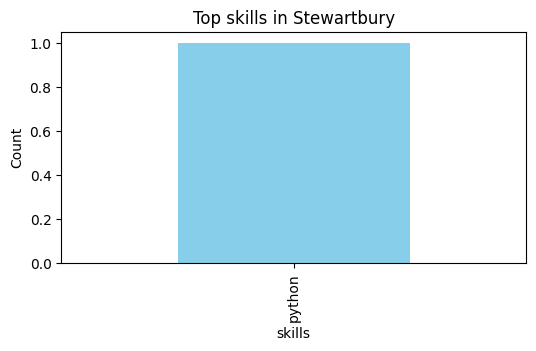

In [16]:
top_locations = df['loc_simple'].value_counts().head(5).index.tolist()
for loc in top_locations:
    data = top_skills_by_loc[top_skills_by_loc['loc_simple']==loc].set_index('skills')['count']
    if not data.empty:
        data.plot(kind='bar', figsize=(6,3), color="skyblue", title=f"Top skills in {loc}")
        plt.ylabel("Count")
        plt.show()
